# Overview of this jupyter notebook

1. Load feature & label and split into train & test data
2. First Classification with a random model
3. Evaluate the trained model with confusion matrix
4. Search and visualize wrongly predicted curves in each class

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
import pickle
import json
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, clone_model, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax
import keras_tuner as kt

In [3]:
import os
import importlib
from library import etl_data as etl             # this module contains functions that load, visualize and save the data
from library import faps_color as fapsc         # this module contains the color combination of FAPS Institute
from library import classification_util as cu   # this module contains helper functions for the classification task
print(importlib.reload(etl))
print(importlib.reload(fapsc))
print(importlib.reload(cu))

<module 'library.etl_data' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\Code\\library\\etl_data.py'>
<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\Code\\library\\faps_color.py'>
<module 'library.classification_util' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\Code\\library\\classification_util.py'>


In [4]:
# GPU check

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("TensorFlow version: ", tf.__version__)
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("Name: ", tf.test.gpu_device_name())
else:
    print("TensorFlow version: ", tf.__version__)
    print("GPU is not available")

TensorFlow version:  2.8.0
Num GPUs Available:  1
Name:  /device:GPU:0


## 1. Load feature & label and split into train & test data

In [5]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [6]:
df0 = pd.read_pickle("dataframes/df0_v4.1.pkl")
df1 = pd.read_pickle("dataframes/df1_v4.1.pkl")
df2 = pd.read_pickle("dataframes/df2_v4.1.pkl")
df3 = pd.read_pickle("dataframes/df3_v4.1.pkl")
df4 = pd.read_pickle("dataframes/df4_v4.1.pkl")
df5 = pd.read_pickle("dataframes/df5_v4.1.pkl")
df6 = pd.read_pickle("dataframes/df6_v4.1.pkl")
df7 = pd.read_pickle("dataframes/df7_v4.1.pkl")

In [7]:
df0 = df0[df0.columns[:200]]
df0.shape

(775, 200)

In [8]:
# important for searching misclassified curves in each df

df_list = [df0, df1, df2, df3, df4, df5, df6, df7]

In [20]:
feature = np.load('feature_label/feature_single_v4.1.npy')
feature.shape

(1600, 920)

In [21]:
label = np.load("feature_label/label_single_v4.1.npy")
label = to_categorical(label)
label.shape

(1600, 8)

In [22]:
# normalize the fature by dividing max value of feature

max_feat = np.max(feature)
feature_scaled = feature / max_feat

print(max_feat, feature_scaled.shape)

2.56704 (1600, 920)


In [23]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(feature_scaled, label, random_state=13, test_size=0.25, shuffle=True)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_test)

(1200, 920)
(1200, 8)
(400, 920)
(400, 8)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [24]:
y_test_converted = np.argmax(y_test, axis=1)
y_test_converted

array([4, 6, 2, 4, 4, 7, 0, 7, 0, 1, 0, 5, 3, 2, 5, 7, 7, 4, 4, 7, 7, 3,
       3, 0, 2, 0, 0, 5, 4, 6, 7, 4, 2, 6, 6, 2, 1, 0, 0, 6, 4, 7, 6, 3,
       6, 6, 3, 6, 2, 5, 3, 7, 6, 6, 6, 4, 2, 5, 5, 7, 1, 0, 5, 3, 4, 2,
       0, 3, 7, 2, 6, 0, 6, 2, 3, 6, 1, 7, 6, 3, 5, 4, 6, 4, 4, 5, 7, 4,
       3, 1, 6, 1, 5, 2, 5, 3, 1, 3, 7, 4, 3, 6, 7, 6, 6, 7, 4, 6, 4, 2,
       7, 6, 1, 4, 3, 2, 1, 4, 4, 4, 6, 3, 0, 2, 7, 6, 3, 3, 1, 7, 1, 1,
       0, 1, 1, 0, 4, 0, 4, 5, 2, 7, 5, 7, 1, 6, 2, 0, 2, 3, 4, 5, 1, 1,
       7, 3, 3, 5, 5, 2, 1, 0, 2, 0, 6, 5, 3, 1, 3, 0, 2, 3, 2, 6, 1, 3,
       5, 1, 7, 5, 6, 4, 4, 5, 0, 2, 6, 4, 1, 3, 0, 1, 2, 4, 7, 4, 4, 7,
       2, 4, 4, 4, 5, 4, 7, 2, 4, 2, 5, 6, 3, 2, 3, 5, 5, 0, 1, 2, 1, 2,
       7, 0, 6, 3, 2, 3, 1, 1, 7, 4, 1, 6, 4, 7, 1, 6, 4, 0, 1, 3, 6, 6,
       6, 0, 5, 6, 2, 0, 0, 0, 5, 4, 2, 4, 4, 5, 3, 5, 6, 1, 3, 5, 4, 3,
       6, 6, 7, 6, 1, 2, 4, 0, 7, 1, 6, 2, 7, 6, 3, 6, 0, 3, 0, 7, 5, 4,
       2, 4, 5, 0, 2, 6, 1, 3, 4, 1, 7, 4, 2, 0, 0,

In [25]:
unique, counts = np.unique(y_test_converted, return_counts=True)
dict(zip(unique, counts))

{0: 50, 1: 46, 2: 45, 3: 53, 4: 62, 5: 46, 6: 57, 7: 41}

In [26]:
# reshape train data in 3 dimensinal shape
len_curve = feature.shape[1]
print(len_curve)

x_train = x_train.reshape(-1, len_curve, 1)
x_test = x_test.reshape(-1, len_curve, 1)
print(x_train.shape)
print(x_test.shape)

920
(1200, 920, 1)
(400, 920, 1)


## 2. Load optmized 1D-CNN-modell

In [27]:
loaded_model = tf.keras.models.load_model('results/1d_cnn_model_v4.1.h5')
loaded_model.summary()

Model: "sequential_4006"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12009 (Conv1D)       (None, 913, 48)           432       
                                                                 
 max_pooling1d_12009 (MaxPoo  (None, 304, 48)          0         
 ling1D)                                                         
                                                                 
 conv1d_12010 (Conv1D)       (None, 297, 48)           18480     
                                                                 
 max_pooling1d_12010 (MaxPoo  (None, 99, 48)           0         
 ling1D)                                                         
                                                                 
 batch_normalization_4003 (B  (None, 99, 48)           192       
 atchNormalization)                                              
                                                   

## 3. Evaluate the trained model with confusion matrix

In [28]:
loaded_model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 12ms/step - loss: 0.0852 - accuracy: 0.9800


[0.08518471568822861, 0.9800000190734863]

In [61]:
y_pred = np.argmax(loaded_model.predict(x_test), axis=-1)
y_pred

array([4, 6, 2, 4, 4, 7, 0, 7, 0, 1, 0, 5, 3, 2, 5, 7, 7, 4, 4, 7, 7, 3,
       3, 0, 2, 0, 0, 5, 4, 6, 7, 4, 2, 6, 6, 2, 1, 0, 0, 6, 4, 7, 6, 3,
       6, 6, 3, 6, 2, 5, 3, 7, 6, 6, 6, 4, 2, 4, 5, 7, 1, 0, 5, 3, 4, 2,
       0, 3, 7, 2, 4, 0, 6, 2, 3, 6, 1, 7, 6, 3, 5, 4, 6, 4, 4, 5, 7, 4,
       3, 1, 6, 1, 5, 2, 5, 3, 1, 3, 7, 4, 3, 6, 7, 6, 6, 7, 4, 6, 4, 2,
       7, 6, 1, 2, 3, 2, 1, 4, 4, 4, 6, 3, 0, 2, 7, 6, 3, 3, 1, 7, 1, 1,
       0, 1, 1, 0, 4, 0, 4, 5, 2, 7, 5, 7, 1, 6, 2, 0, 2, 3, 4, 5, 1, 1,
       7, 3, 3, 5, 5, 2, 1, 0, 2, 0, 6, 5, 3, 1, 3, 0, 2, 3, 2, 6, 1, 3,
       5, 4, 7, 5, 6, 4, 4, 5, 0, 2, 6, 4, 1, 3, 0, 1, 2, 4, 7, 4, 4, 7,
       2, 4, 4, 4, 5, 4, 7, 2, 4, 2, 5, 6, 3, 2, 3, 5, 5, 0, 1, 2, 1, 2,
       7, 0, 6, 3, 2, 3, 1, 1, 7, 7, 1, 6, 4, 7, 1, 6, 4, 0, 1, 3, 6, 6,
       6, 0, 5, 6, 2, 0, 0, 0, 5, 4, 2, 7, 4, 5, 3, 5, 6, 1, 3, 5, 4, 3,
       6, 6, 7, 6, 1, 2, 4, 0, 7, 1, 6, 2, 7, 6, 3, 6, 0, 3, 0, 7, 5, 4,
       2, 7, 5, 0, 2, 6, 1, 3, 4, 1, 7, 4, 2, 0, 0,

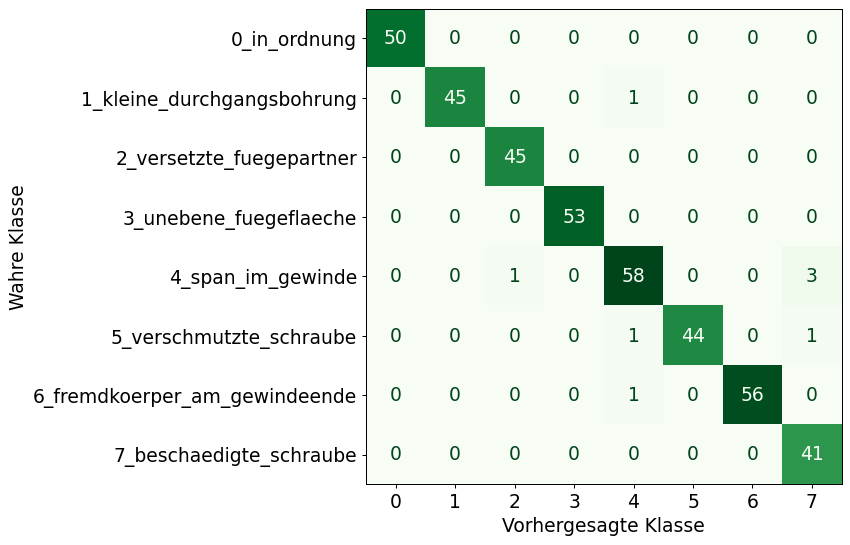

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.98      0.99        46
           2       0.98      1.00      0.99        45
           3       1.00      1.00      1.00        53
           4       0.95      0.94      0.94        62
           5       1.00      0.96      0.98        46
           6       1.00      0.98      0.99        57
           7       0.91      1.00      0.95        41

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



In [62]:
cu.plot_calc_cm(y_test_converted, y_pred, classes, dpi=90)

## 4. Search and visualize wrongly predicted curves in each class

In [146]:
wrong_pred_dict = {"df0": {"df_col": [], "true": [], "misclassified_as": []},
                   "df1": {"df_col": [], "true": [], "misclassified_as": []},
                   "df2": {"df_col": [], "true": [], "misclassified_as": []},
                   "df3": {"df_col": [], "true": [], "misclassified_as": []},
                   "df4": {"df_col": [], "true": [], "misclassified_as": []},
                   "df5": {"df_col": [], "true": [], "misclassified_as": []},
                   "df6": {"df_col": [], "true": [], "misclassified_as": []},
                   "df7": {"df_col": [], "true": [], "misclassified_as": []}}

In [147]:
x_test_df = pd.DataFrame(x_test.reshape(-1, len_curve).transpose())
x_test_df_inverse = x_test_df*max_feat
x_test_df_inverse

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0.00000,0.01344,0.00000,0.00448,0.00000,0.01344,0.00448,0.00000,0.00896,0.01344,...,0.00000,0.02240,0.01344,0.00000,0.02240,0.02688,0.03136,0.00000,0.01344,0.02240
1,0.00000,0.00896,0.00000,0.00448,0.00000,0.01344,0.00448,0.00000,0.00896,0.01344,...,0.00000,0.02240,0.01344,0.00000,0.02240,0.02688,0.03136,0.00000,0.01344,0.02240
2,0.00448,0.00000,0.00000,0.00896,0.00896,0.01792,0.00448,0.00896,0.00896,0.00448,...,0.00448,0.00448,0.01344,0.00000,0.00896,0.00896,0.02688,0.00000,0.00448,0.01792
3,0.00896,0.00000,0.00448,0.01344,0.01344,0.00896,0.00896,0.00896,0.00896,0.00000,...,0.00896,0.00000,0.00448,0.00448,0.00000,0.00896,0.00896,0.00896,0.00000,0.01344
4,0.01344,0.00000,0.00896,0.01344,0.01792,0.02240,0.01344,0.01792,0.01344,0.00448,...,0.01344,0.00448,0.01792,0.00896,0.00896,0.00896,0.02688,0.01344,0.00448,0.01792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
916,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
917,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
918,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [139]:
from library import classification_util as cu
print(importlib.reload(cu))

<module 'library.classification_util' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\Code\\library\\classification_util.py'>


In [148]:
wrong_predictions = cu.find_misclassification_with_duplicates(y_true, y_pred, df_list, wrong_pred_dict,
                                                              x_test_df_inverse, rounding=4)

In [149]:
wrong_predictions

{'df0': {'df_col': [], 'true': [], 'misclassified_as': []},
 'df1': {'df_col': [1], 'true': [1], 'misclassified_as': [4]},
 'df2': {'df_col': [], 'true': [], 'misclassified_as': []},
 'df3': {'df_col': [], 'true': [], 'misclassified_as': []},
 'df4': {'df_col': [195, 129, 192, 96],
  'true': [4, 4, 4, 4],
  'misclassified_as': [2, 7, 7, 7]},
 'df5': {'df_col': [8, 123], 'true': [5, 5], 'misclassified_as': [4, 7]},
 'df6': {'df_col': [127], 'true': [6], 'misclassified_as': [4]},
 'df7': {'df_col': [], 'true': [], 'misclassified_as': []}}

In [144]:
#with open("results/wrong_predicted_curves_v4.1.pkl", "wb") as f:
#    pickle.dump(wrong_pred_dict, f)

In [145]:
#with open("results/wrong_predicted_curves_v4.1.pkl", "rb") as f:
#    wrong_predictions = pickle.load(f)

### main function of the notebook -> search wrongly classified curves and visualize it

- every curve is saved as a csv file in different folders with numberings -> e.g. class0_3 means curve from class 0 nr 3
- this numbering is equal to the col number of each dataframes 
- with the function "find_misclassification_with_duplicates" in classification_util.py file can be identified which curve 
  in x_test is wrongly classified
- benefit of visualizing wrongliy classified curves are:
1. figure out with curve has to be replaced
2. develop a strategy in model building to avoid misclassification

## class 0

In [150]:
df0w = pd.DataFrame(wrong_predictions["df0"]).sort_values(by=["df_col"])
df0w

,df_col,true,misclassified_as


## class 1

In [151]:
df1w = pd.DataFrame(wrong_predictions["df1"]).sort_values(by=["df_col"])
df1w

,df_col,true,misclassified_as
0,1,1,4


In [260]:
from library import classification_util as cu
print(importlib.reload(cu))

<module 'library.classification_util' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\Code\\library\\classification_util.py'>


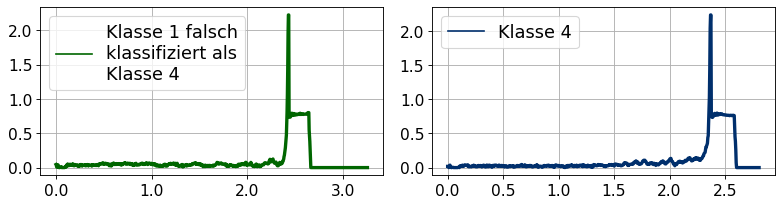

In [261]:
cu.plot_wrong_preds(df1, df1w["df_col"].iloc[0], fapsc.dark_green, f"Klasse 1 falsch\nklassifiziert als\nKlasse 4", 
                    df4[0], fapsc.blue, f"Klasse 4", figsize=(10, 2.8), dpi=80)

## class 2

In [152]:
df2w = pd.DataFrame(wrong_predictions["df2"]).sort_values(by=["df_col"])
df2w

,df_col,true,misclassified_as


## class 3

In [153]:
df3w = pd.DataFrame(wrong_predictions["df3"]).sort_values(by=["df_col"])
df3w

,df_col,true,misclassified_as


## class 4

In [154]:
df4w = pd.DataFrame(wrong_predictions["df4"]).sort_values(by=["df_col"])
df4w

,df_col,true,misclassified_as
3,96,4,7
1,129,4,7
2,192,4,7
0,195,4,2


In [193]:
from library import classification_util as cu
print(importlib.reload(cu))

<module 'library.classification_util' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\Code\\library\\classification_util.py'>


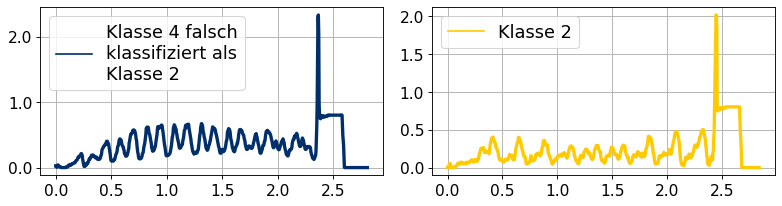

In [255]:
cu.plot_wrong_preds(df4, df4w["df_col"].iloc[-1], fapsc.blue, f"Klasse 4 falsch\nklassifiziert als\nKlasse 2", 
                    df2[2], fapsc.yellow, f"Klasse 2", figsize=(10, 2.8), dpi=80)

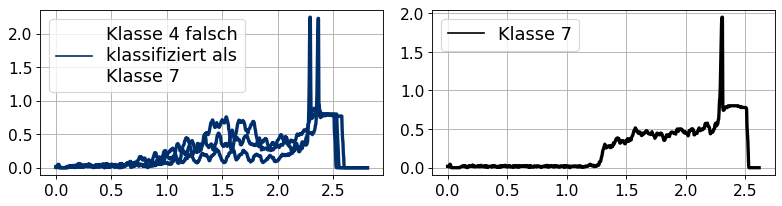

In [256]:
cu.plot_wrong_preds(df4, df4w["df_col"].iloc[:3], fapsc.blue, f"Klasse 4 falsch\nklassifiziert als\nKlasse 7", 
                    df7[4], fapsc.black, f"Klasse 7", figsize=(10, 2.8), dpi=80)

## class 5

In [212]:
df5w = pd.DataFrame(wrong_predictions["df5"]).sort_values(by=["df_col"])
df5w

,df_col,true,misclassified_as
0,8,5,4
1,123,5,7


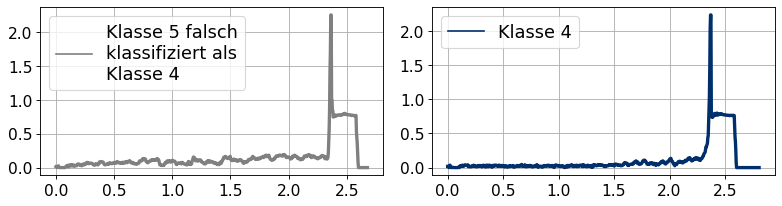

In [257]:
cu.plot_wrong_preds(df5, df4w["df_col"].iloc[0], fapsc.grey_0, f"Klasse 5 falsch\nklassifiziert als\nKlasse 4", 
                    df4[0], fapsc.blue, f"Klasse 4", figsize=(10, 2.8), dpi=80)

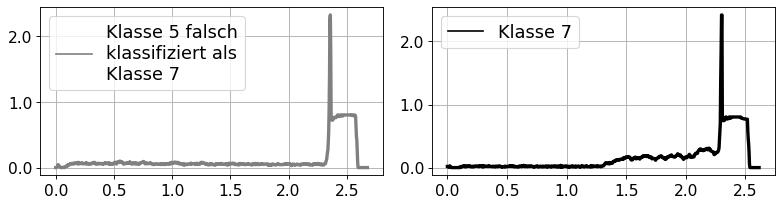

In [258]:
cu.plot_wrong_preds(df5, df4w["df_col"].iloc[1], fapsc.grey_0, f"Klasse 5 falsch\nklassifiziert als\nKlasse 7", 
                    df7[6], fapsc.black, f"Klasse 7", figsize=(10, 2.8), dpi=80)

## class 6

In [237]:
df6w = pd.DataFrame(wrong_predictions["df6"]).sort_values(by=["df_col"])
df6w

,df_col,true,misclassified_as
0,127,6,4


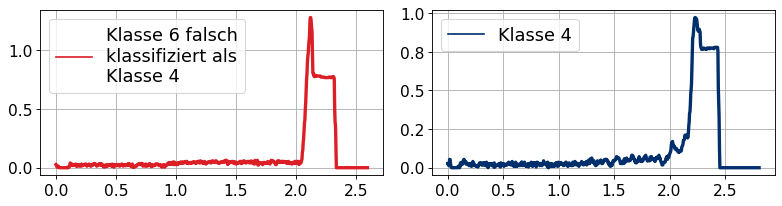

In [259]:
cu.plot_wrong_preds(df6, df6w["df_col"].iloc[0], fapsc.red, f"Klasse 6 falsch\nklassifiziert als\nKlasse 4", 
                    df4[105], fapsc.blue, f"Klasse 4", figsize=(10, 2.8), dpi=80)

## class 7

In [250]:
df7w = pd.DataFrame(wrong_predictions["df7"]).sort_values(by=["df_col"])
df7w

,df_col,true,misclassified_as
